# Dask 101

Sources:
- [Dask overview](https://tutorial.dask.org/00_overview.html)
- [Xarray and Dask](https://tutorial.xarray.dev/intermediate/xarray_and_dask.html)

## Overview: What is Dask?

Dask is a parallel and distributed computing library that scales the existing Python and PyData ecosystem.

Dask can scale up to your full laptop capacity and out to a cloud cluster.

There are many parts to the “Dask” the project:
- **Collections/API** also known as “core-library”.
- **Distributed** – to create clusters
- **Intergrations and broader ecosystem**

### Dask Collections

Dask provides `multi-core` and `distributed+parallel` execution on `larger-than-memory` datasets

We can think of Dask’s APIs (also called collections) at a high and a low level:

![](https://tutorial.dask.org/_images/high_vs_low_level_coll_analogy.png)

### Dask Cluster

Most of the times when you are using Dask, you will be using a distributed scheduler, which exists in the context of a Dask cluster. The Dask cluster is structured as:

![](https://tutorial.dask.org/_images/distributed-overview.png)

### Quick demo of dask

In [1]:
import dask.dataframe as dd
from dask.distributed import Client

# Create and connect to a local dask cluster
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63081,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:63096,Total threads: 2
Dashboard: http://127.0.0.1:63103/status,Memory: 6.40 GiB
Nanny: tcp://127.0.0.1:63084,


:::{tip}
You can click on the **Dashboard** link above to open a new tab for the dask dashboard to get a full information about your workers, tasks, resources, etc.
:::

Now we'll read [Apache Parquet](https://parquet.apache.org/) files from an [AWS S3 Bucket](https://aws.amazon.com/s3/) into a [Dask Dataframe](https://docs.dask.org/en/stable/dataframe.html) object. We’re reading the NYC taxi cab data from 2015.

In [2]:
ddf = dd.read_parquet(
    "s3://dask-data/nyc-taxi/nyc-2015.parquet/part.*.parquet",
    columns=["passenger_count", "tip_amount"],
    storage_options={"anon": True},
)

:::{hint}
A Dask DataFrame is a large parallel DataFrame composed of many smaller pandas DataFrames, split along the index.
:::

In [3]:
ddf

,passenger_count,tip_amount
npartitions=50,,
,int32,float64
,...,...
...,...,...
,...,...
,...,...


Let's perform some computation below. Here we're figuring out the average tip amount.

In [5]:
result = ddf.groupby("passenger_count").tip_amount.mean().compute()
result

passenger_count
0    1.590343
1    1.752130
2    1.705595
3    1.579748
4    1.459269
5    1.728534
6    1.680769
7    3.863473
8    5.060718
9    5.075917
Name: tip_amount, dtype: float64

:::{tip}
While waiting for the computation to finish, you can hop over to dask dashboard to see your computation happening in parallel in real time!
:::

## General parallelization

Often in data processing, we're faced in having to go through a bunch of the same computation over and over again. This can be very daunting and takes a very long time.

For example, a typical workflow may be an ETL(Extract-Transform-Load) pipeline:

```python
def process_file(filename):
    data = read_a_file(filename)
    data = do_a_transformation(data)
    destination = f"results/{filename}"
    write_out_data(data, destination)
    return destination

results = []
for filename in filenames:
    results.append(process_file(filename))
```

Here we're processing n number of files individually in a for-loop, which means that this will take n number of time depending on the number of files since it's computing sequentially.

### Dask Delayed

This kind of computation can be improved with dask, simply by adding `@delayed` to the function:

```python
import dask

@dask.delayed
def process_file(filename):
    # Rest of function
    ...

# For loop
...

# Now compute the results
dask.compute(results)
```

This will now allow your processing to run in parallel (all at once if you have enough workers).

![](https://uploads.sitepoint.com/wp-content/uploads/2022/07/1658988061serial_parallel_diagram.jpg)

What is seen above is called [**Dask Delayed**](https://docs.dask.org/en/latest/delayed.html).

The Dask delayed function decorates your functions so that they operate **lazily**. Rather than executing your function immediately, it will defer execution, placing the function and its arguments into a task graph.

This is why you have to specifically tell dask to compute by calling `dask.compute`.

Here's another example that we can execute live:

In [6]:
import dask, distributed

In [7]:
print("Dask version:", dask.__version__)
print("Dask distributed version:", distributed.__version__)

Dask version: 2023.8.0
Dask distributed version: 2023.8.0


In [8]:
@dask.delayed
def inc(x):
    return x + 1

@dask.delayed
def double(x):
    return x * 2

@dask.delayed
def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

# Calculate sum... you can also wrap a function such as sum
total = dask.delayed(sum)(output)

In [9]:
# See that it's a delayed function
total

Delayed('sum-ec0521d4-a6b7-4440-9a23-6d78fbca2c3b')

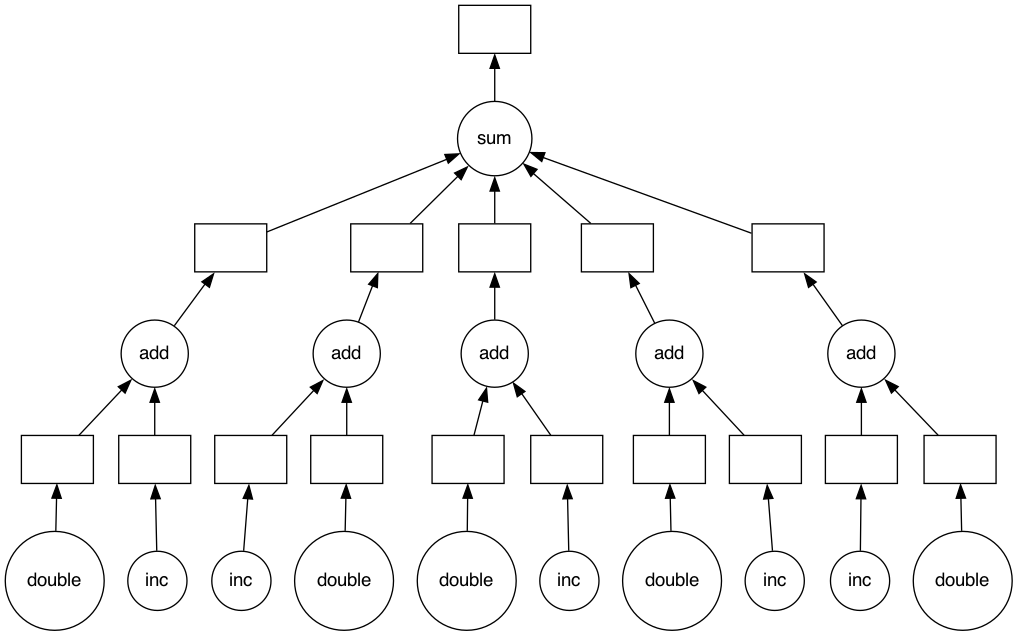

In [10]:
# See the task graph
total.visualize()

We can now compute this lazy result to execute the graph in parallel:

In [11]:
total.compute()

50

In the instance above is typically how `delayed` is used throughout various libraries. This is often the case because such routines are called CPU Bound computation, there are many calculations that happens.

### Dask Futures

Sometimes, we face a task to maybe fetch data from multiple urls. You may think that we can probably just request from all of these urls all at once using the delayed method above. Here's the catch though, some of the sites might be slower than others and so we might have to wait for that particular site, while processing the others continue.

This is a common problem with I/O bound tasks. Ideally the first example of ETL should use dask futures rather than dask delayed since there are a lot of read and write happening.

The futures interface (derived from the built-in `concurrent.futures`) provide fine-grained real-time execution for custom situations. We can submit individual functions for evaluation with one set of inputs, or evaluated over a sequence of inputs with `submit()` and `map()`. The call returns **immediately**, giving one or more futures, whose status begins as "pending" and later becomes "finished". There is no blocking of the local Python session.

This is the important difference between `futures` and `delayed`. Both can be used to support arbitrary task scheduling, but delayed is lazy (it just constructs a graph) whereas futures are eager. With futures, as soon as the inputs are available and there is compute available, the computation starts.

:::{note}
You must start a Client to use the futures interface. This tracks state among the various worker processes or threads
:::

We'll use the client that has been spun up for the demo above

In [12]:
import urllib.request

URLS = ['http://www.foxnews.com/',
        'http://www.cnn.com/',
        'http://europe.wsj.com/',
        'http://www.bbc.co.uk/',
        'http://nonexistant-subdomain.python.org/']

In [13]:
# Retrieve a single page and report the URL and content length
def load_url(url, timeout):
    try:
        with urllib.request.urlopen(url, timeout=timeout) as conn:
            return url, conn.headers.get('Content-Length')
    except Exception:
        return url, None

#### `client.map`

`client.map` maps a function on a sequence of arguments

In [14]:
from dask.distributed import as_completed

# Create futures
futures = client.map(load_url, URLS, timeout=60)

# Get results as the request completed
for future, result in as_completed(futures, with_results=True):
    print(future.status, result)

finished ('http://nonexistant-subdomain.python.org/', None)
finished ('http://www.cnn.com/', '2710552')
finished ('http://www.foxnews.com/', '601902')
finished ('http://www.bbc.co.uk/', '591581')
finished ('http://europe.wsj.com/', None)


#### `client.submit`

`client.submit` takes a function and arguments, pushes these to the cluster, returning a `Future` representing the result to be computed. The function is passed to a worker process for evaluation. This looks a lot like doing `client.compute()`, above, except now we are passing the function and arguments directly to the cluster.

In [15]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1


future_x = client.submit(inc, 1)
future_y = client.submit(inc, 2)
future_z = client.submit(sum, [future_x, future_y])
future_z

<Future: pending, key: sum-0ca3af4f3ecdecfaadfaf1876bdcc14a>

In [16]:
future_z.result()  # waits until result is ready

5

:::{note}
The futures API offers a work submission style that can easily emulate the map/reduce paradigm. If that is familiar to you then futures might be the simplest entrypoint into Dask.

The other big benefit of futures is that the intermediate results, represented by futures, can be passed to new tasks without having to pull data locally from the cluster. New operations can be setup to work on the output of previous jobs that haven’t even begun yet.
:::

## Dask and Xarray

```{important}
Using Dask does not always make your computations run faster!* 
```

Performance will depend on the computational infrastructure you're using (for example, how many CPU cores), how the data you're working with is structured and stored, and the algorithms and code you're running. Be sure to review the [Dask best-practices](https://docs.dask.org/en/stable/best-practices.html) if you're new to Dask!

When we talk about Xarray + Dask, we are *usually* talking about two things:
1. `dask.array` as a drop-in replacement for numpy arrays
2. A "scheduler" that actually runs computations on dask arrays (commonly [distributed](https://docs.dask.org/en/stable/deploying.html))

In [17]:
import dask
import dask.array

darr = dask.array.ones((10, 5), chunks=(2, 2))

In [18]:
darr

dask.array<ones_like, shape=(10, 5), dtype=float64, chunksize=(2, 2), chunktype=numpy.ndarray>

Dask arrays are lazy, similar to the `delayed` functions above, so operations are not computed until you explicitely request them.

In [19]:
darr.mean(axis=-1)

dask.array<mean_agg-aggregate, shape=(10,), dtype=float64, chunksize=(2,), chunktype=numpy.ndarray>

So what did dask do when you called `.mean`? It added that operation to the "graph" or a blueprint of operations to execute later.

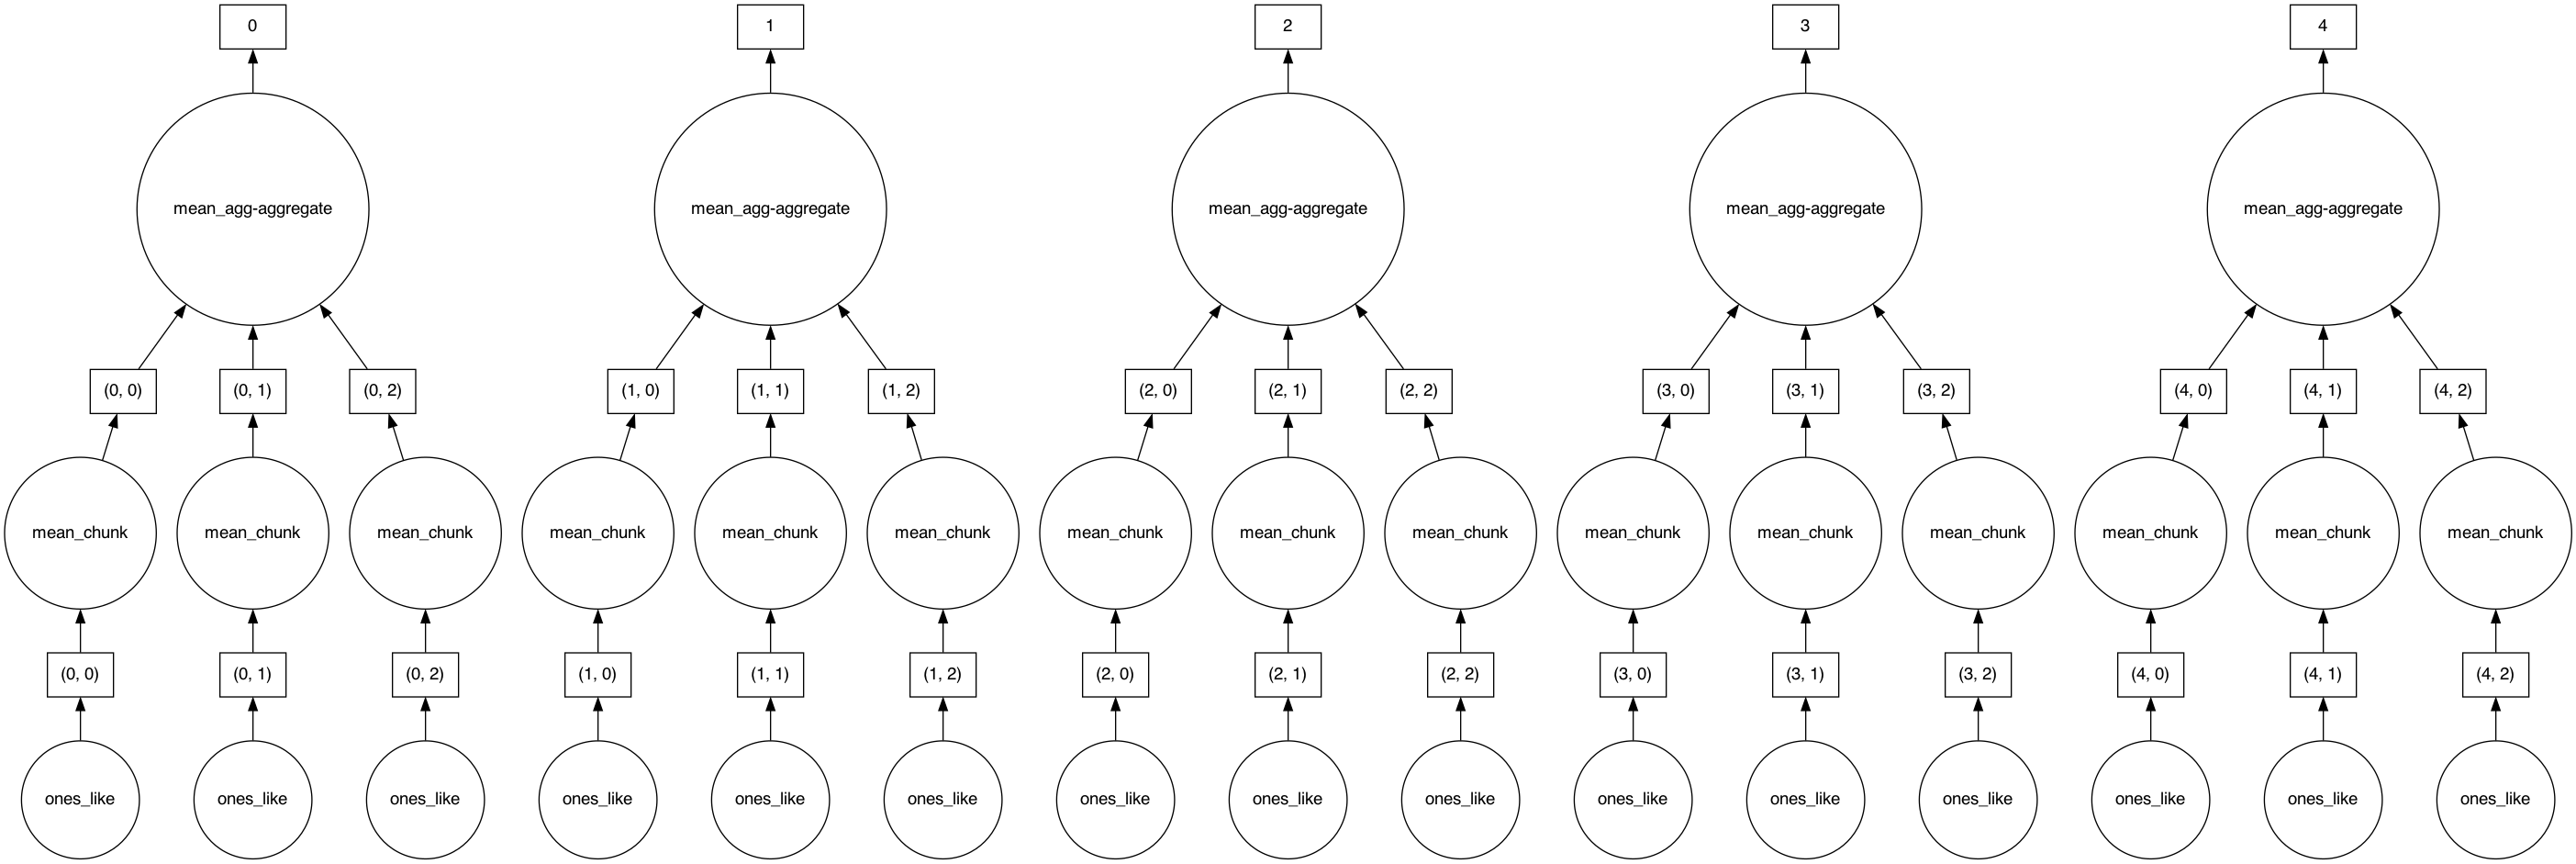

In [20]:
dask.visualize(darr.mean(axis=-1))

In [21]:
# Now we actually compute
darr.mean(axis=-1).compute()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Xarray can wrap dask arrays, and we use Xarray to enable using our metadata to express our analysis.

### Creating dask-backed Xarray objects

The `chunks` argument to both `open_dataset` and `open_mfdataset` allow you to
read datasets as dask arrays. 

In [22]:
%xmode minimal

import numpy as np
import xarray as xr

# limit the amount of information printed to screen
xr.set_options(display_expand_data=False)
np.set_printoptions(threshold=10, edgeitems=2)

Exception reporting mode: Minimal


In [23]:
# Let's open a standard tutorial data again
ds = xr.tutorial.open_dataset("air_temperature")
ds.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
[3869000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [24]:
# This time with dask array
ds = xr.tutorial.open_dataset(
    "air_temperature",
    chunks={  # this tells xarray to open the dataset as a dask array
        "lat": "auto",
        "lon": 25,
        "time": -1,
    },
)
ds.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

The representation ("repr" in Python parlance) for the `air` DataArray shows the very nice HTML dask array repr. You can access the underlying chunk sizes using `.chunks`:

In [25]:
ds.air.chunks

((2920,), (25,), (25, 25, 3))

```{tip}
All variables in a `Dataset` need _not_ have the same chunk size along
common dimensions.
```

### Extracting underlying data

There are two ways to pull out the underlying array object in an xarray object.

1. `.to_numpy` or `.values` will always return a NumPy array. For dask-backed xarray objects,
   this means that compute will always be called
2. `.data` will return a Dask array

```{tip}
Use `to_numpy` or `as_numpy` instead of `.values` so that your code generalizes to other array types (like CuPy arrays, sparse arrays)
```

In [26]:
ds.air.data  # dask array, not numpy

dask.array<open_dataset-air, shape=(2920, 25, 53), dtype=float32, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>

In [27]:
ds.air.as_numpy().data  ## numpy array

array([[[241.2    , 242.5    , ..., 235.5    , 238.59999],
        [243.79999, 244.5    , ..., 235.29999, 239.29999],
        ...,
        [295.9    , 296.19998, ..., 295.9    , 295.19998],
        [296.29   , 296.79   , ..., 296.79   , 296.6    ]],

       [[242.09999, 242.7    , ..., 233.59999, 235.79999],
        [243.59999, 244.09999, ..., 232.5    , 235.7    ],
        ...,
        [296.19998, 296.69998, ..., 295.5    , 295.1    ],
        [296.29   , 297.19998, ..., 296.4    , 296.6    ]],

       ...,

       [[245.79   , 244.79   , ..., 243.98999, 244.79   ],
        [249.89   , 249.29   , ..., 242.48999, 244.29   ],
        ...,
        [296.29   , 297.19   , ..., 295.09   , 294.38998],
        [297.79   , 298.38998, ..., 295.49   , 295.19   ]],

       [[245.09   , 244.29   , ..., 241.48999, 241.79   ],
        [249.89   , 249.29   , ..., 240.29   , 241.68999],
        ...,
        [296.09   , 296.88998, ..., 295.69   , 295.19   ],
        [297.69   , 298.09   , ..., 296.19  

### Lazy computation

Xarray seamlessly wraps dask so all computation is deferred until explicitly
requested.

In [28]:
mean = ds.air.mean("time")
mean

<xarray.DataArray 'air' (lat: 25, lon: 53)>
dask.array<chunksize=(25, 25), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0

Dask actually constructs a graph of the required computation. Here it's pretty simple: The full array is subdivided into 3 arrays. Dask will load each of these subarrays in a separate thread using the default [single-machine scheduling](https://docs.dask.org/en/stable/scheduling.html). You can visualize dask 'task graphs' which represent the requested computation:

In [29]:
mean.data  # dask array

dask.array<mean_agg-aggregate, shape=(25, 53), dtype=float32, chunksize=(25, 25), chunktype=numpy.ndarray>

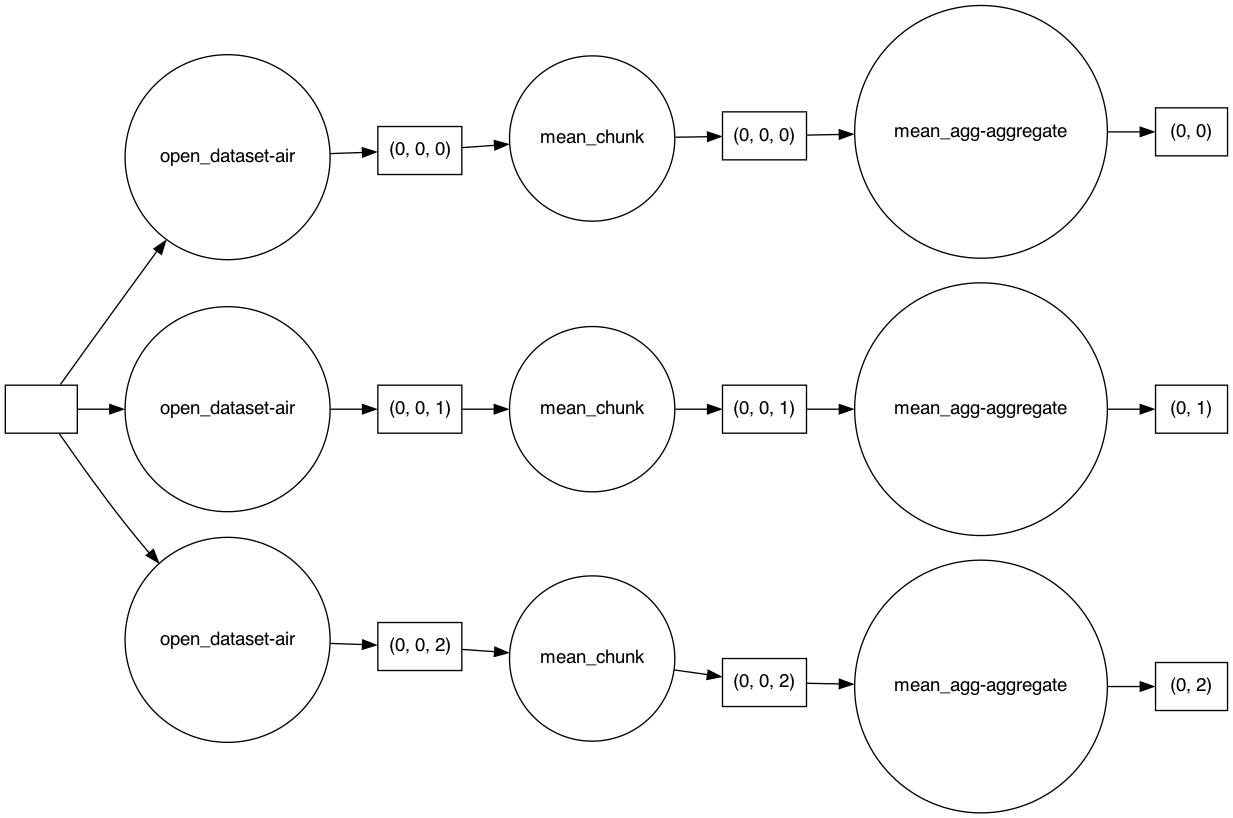

In [30]:
# visualize the graph for the underlying dask array
# we ask it to visualize the graph from left to right because it looks nicer
dask.visualize(mean.data, rankdir="LR")

### Getting concrete values

At some point, you will want to actually get concrete values (_usually_ a numpy array) from dask.

There are two ways to compute values on dask arrays.

1. `.compute()` returns an xarray object *just like a dask array*
2. `.load()` replaces the dask array in the xarray object with a numpy array.
   This is equivalent to `ds = ds.compute()`
   
```{tip}
There is a third option : "persisting". `.persist()` loads the values into distributed RAM. The values are computed but remain distributed across workers. So `ds.air.persist()` still returns a dask array. This is useful if you will be repeatedly using a dataset for computation but it is too large to load into local memory. You will see a persistent task on the dashboard. See the [dask user guide](https://docs.dask.org/en/latest/api.html#dask.persist) for more on persisting
```

In [31]:
mean.compute()

<xarray.DataArray 'air' (lat: 25, lon: 53)>
260.4 260.2 259.9 259.5 259.0 258.6 ... 298.0 297.9 297.8 297.3 297.3 297.3
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0

## Distributing your computation

Let's go back to our Xarray Dataset, in addition to computing the mean, other operations such as indexing will automatically use whichever Dask Cluster we are connected to!

In [32]:
ds.air.isel(lon=1, lat=20)

<xarray.DataArray 'air' (time: 2920)>
dask.array<chunksize=(2920,), meta=np.ndarray>
Coordinates:
    lat      float32 25.0
    lon      float32 202.5
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

and more complicated operations...


In [33]:
rolling_mean = ds.air.rolling(time=5).mean()  # no activity on dashboard
rolling_mean  # contains dask array

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [34]:
timeseries = rolling_mean.isel(lon=1, lat=20)  # no activity on dashboard
timeseries  # contains dask array

<xarray.DataArray 'air' (time: 2920)>
dask.array<chunksize=(2920,), meta=np.ndarray>
Coordinates:
    lat      float32 25.0
    lon      float32 202.5
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [35]:
computed = rolling_mean.compute()  # activity on dashboard
computed  # has real numpy values

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
nan nan nan nan nan nan nan nan ... 298.4 297.4 297.3 297.2 296.5 296.1 295.6
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

Note that `rolling_mean` still contains a dask array


In [36]:
rolling_mean

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

```{tip}
While these operations all work, not all of them are necessarily the optimal implementation for parallelism. Usually analysis pipelines need some tinkering and tweaking to get things to work. In particular read the user guidie recommendations for [chunking](https://docs.xarray.dev/en/stable/user-guide/dask.html#chunking-and-performance) and [performance](https://docs.xarray.dev/en/stable/user-guide/dask.html#optimization-tips)
```

### Xarray data structures are first-class dask collections.

This means you can do things like `dask.compute(xarray_object)`,
`dask.visualize(xarray_object)`, `dask.persist(xarray_object)`. This works for
both DataArrays and Datasets

### Finish up
Gracefully shutdown our connection to the Dask cluster. This becomes more important when you are running on large HPC or Cloud servers rather than a laptop!

In [37]:
client.close()

## What's next

1. See the [Xarray user guide on dask](https://docs.xarray.dev/en/stable/user-guide/dask.html).
2. Go throught the full [dask tutorial](https://tutorial.dask.org/)
3. Read about [Dask Gateway](https://gateway.dask.org/) to deploy and manage multi-tenant dask cluster.